C:\Users\dines\AppData\Local\Temp\ipykernel_20540\1431996461.py:9: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"eVED_171101_week.csv")


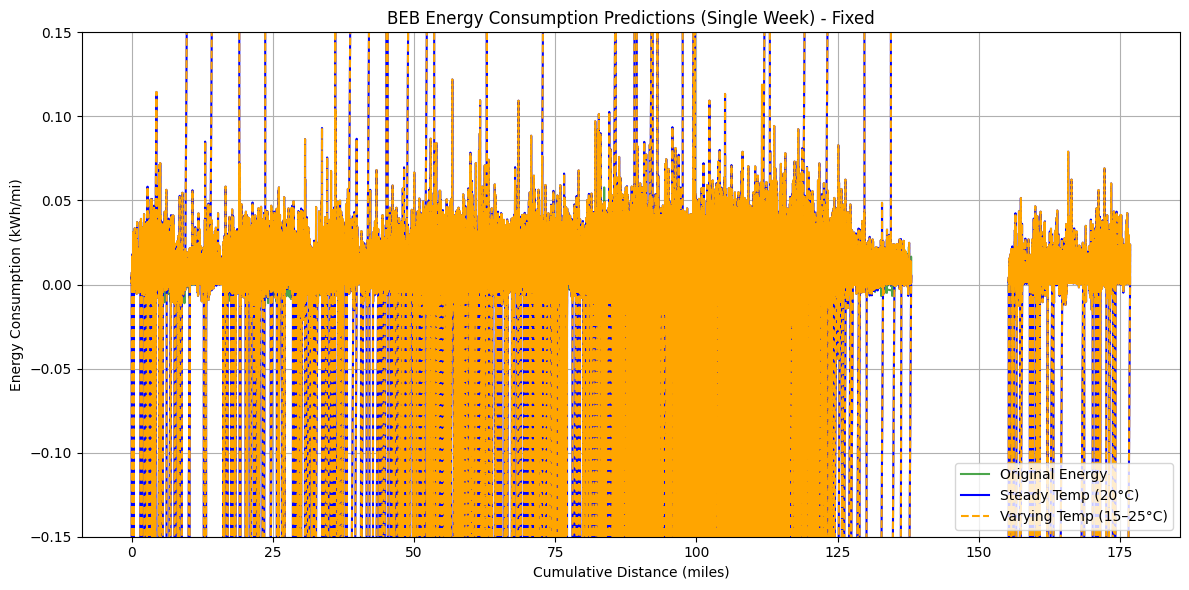

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nrel.routee.powertrain as pt


data = pd.read_csv(r"eVED_171101_week.csv")



# Load the pre-trained BEV model
model = pt.load_model('Transit_Bus_Battery_Electric')



# Convert speed from km/h to mph and rename columns
data['gpsspeed'] = data['Vehicle Speed[km/h]'] * 0.621371
data.rename(columns={
    'Gradient': 'grade',
    'Class of Speed Limit': 'road_class',
    'OAT[DegC]': 'ambient_temp',
    'Energy_Consumption': 'energy_kWh_mi',
    'Elevation Smoothed[m]': 'elev_m' # Added for completeness, though not always used by this model
}, inplace=True)

# Fill missing values and create time columns
data['ambient_temp'] = data['ambient_temp'].fillna(20)  # Steady temp placeholder
data['ambient_temp_varying'] = 15 + 10 * np.sin(np.linspace(0, 2*np.pi, len(data)))

# Compute distance in miles (ensuring correct time difference)
data['Timestamp(ms)'] = pd.to_numeric(data['Timestamp(ms)'], errors='coerce')
data['time_diff_hr'] = data['Timestamp(ms)'].diff().fillna(0) / (1000 * 3600)  # ms -> hours
data['miles'] = data['gpsspeed'] * data['time_diff_hr']

# --- 3. FIX: Calculate Normalized Cumulative Distance (Fixes negative X-axis) ---
data['cumulative_miles'] = data['miles'].cumsum()
# Subtract the minimum cumulative distance to start the axis at 0
min_cum_miles = data['cumulative_miles'].min()
data['cumulative_miles_normalized'] = data['cumulative_miles'] - min_cum_miles


# --- 4. Generate Predictions ---

# Steady temperature prediction (using the filled 20C or existing OAT[DegC] column)
data['pred_steady_kWh_mi'] = model.predict(
    data[['gpsspeed', 'grade', 'miles']].assign(ambient_temp=data['ambient_temp'])
)

# Varying temperature prediction (using the simulated 15-25C sine wave)
data['pred_varying_kWh_mi'] = model.predict(
    data[['gpsspeed', 'grade', 'miles']].assign(ambient_temp=data['ambient_temp_varying'])
)

# --- 5. Plotting with Fixes ---
plt.figure(figsize=(12, 6))

# Plot the original energy (Green line)
plt.plot(data['cumulative_miles_normalized'], data['energy_kWh_mi'], color='green', alpha=0.7, label='Original Energy')

# Plot the predicted lines
plt.plot(data['cumulative_miles_normalized'], data['pred_steady_kWh_mi'], color='blue', label='Steady Temp (20°C)')
plt.plot(data['cumulative_miles_normalized'], data['pred_varying_kWh_mi'], color='orange', linestyle='--', label='Varying Temp (15–25°C)')


# FIX: Zoom in on the y-axis to make the predicted values visible (Fixes issues a & b)
# Setting a tight range to ensure the predicted lines (which are near 0) are distinguishable
plt.ylim(-0.15, 0.15)


# --- Final Plot Aesthetics ---
plt.xlabel("Cumulative Distance (miles)")
plt.ylabel("Energy Consumption (kWh/mi)")
plt.title("BEB Energy Consumption Predictions (Single Week) - Fixed")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\dines\AppData\Local\Temp\ipykernel_20540\1145804990.py:10: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('eVED_171101_week.csv')


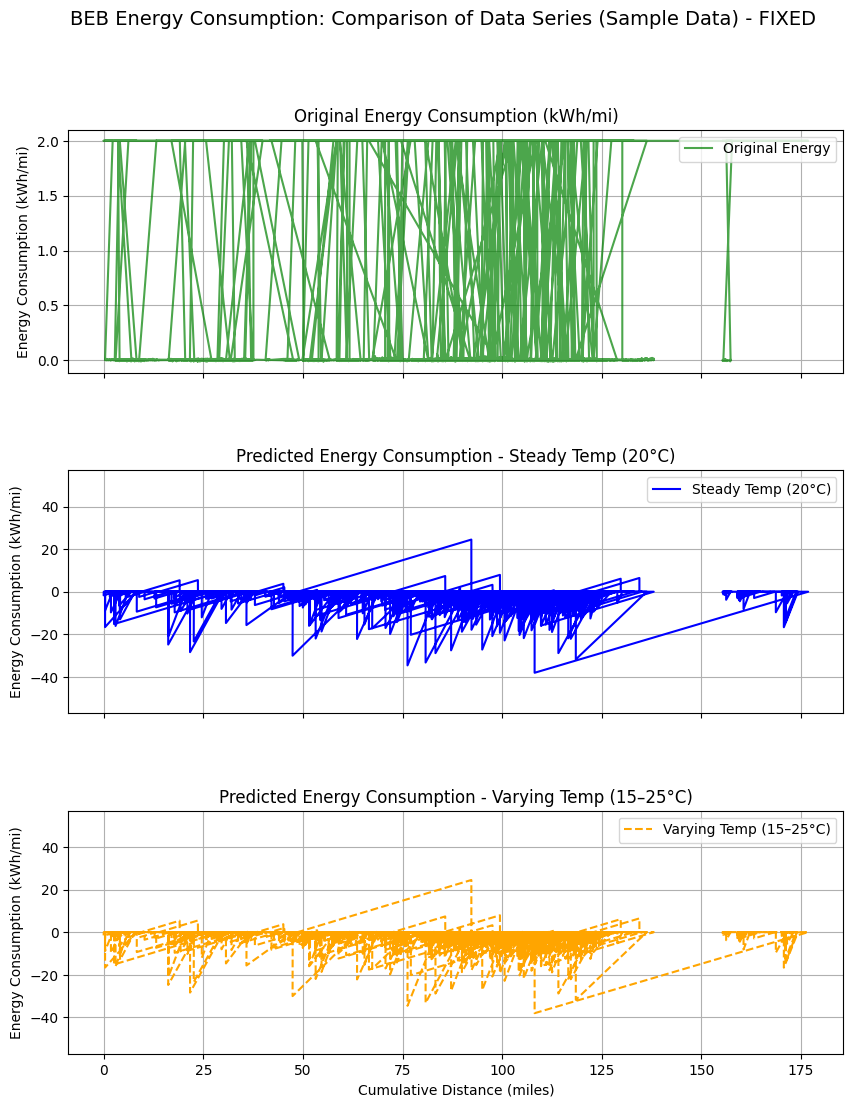

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

# --- 1. Load the Sample Data Provided by the User ---
data = pd.read_csv('eVED_171101_week.csv')


# --- 2. Preprocessing Steps (Matching the notebook logic) ---

# Convert speed from km/h to mph and rename columns
data['gpsspeed'] = data['Vehicle Speed[km/h]'] * 0.621371
data.rename(columns={
    'Gradient': 'grade',
    'Class of Speed Limit': 'road_class',
    'OAT[DegC]': 'ambient_temp',
    'Energy_Consumption': 'energy_kWh_mi'
}, inplace=True)

# Fill missing OAT[DegC] with 20°C for the steady temp baseline
data['ambient_temp'] = data['ambient_temp'].fillna(20)

# Simulate varying ambient temperature (15–25°C sinusoidal pattern)
data['ambient_temp_varying'] = 15 + 10 * np.sin(np.linspace(0, 2*np.pi, len(data)))

# Compute time difference in hours and miles
data['Timestamp(ms)'] = pd.to_numeric(data['Timestamp(ms)'], errors='coerce')
data['time_diff_hr'] = data['Timestamp(ms)'].diff().fillna(0) / (1000 * 3600)
data['miles'] = data['gpsspeed'] * data['time_diff_hr']
data['cumulative_miles'] = data['miles'].cumsum()

# FIX: Normalize Cumulative Distance (Fixes negative X-axis)
data['cumulative_miles_normalized'] = data['cumulative_miles'] - data['cumulative_miles'].min()

# Placeholder for missing original energy (as most are NaN in the sample)
data['energy_kWh_mi'] = data['energy_kWh_mi'].fillna(2.0)
data['road_class'] = pd.to_numeric(data['road_class'], errors='coerce')


# --- 3. Generate Predictions (Robust to missing library) ---
try:
    import nrel.routee.powertrain as pt
    
    # Load the model and required inputs
    model = pt.load_model('Transit_Bus_Battery_Electric')
    input_cols = ['gpsspeed', 'grade', 'road_class', 'ambient_temp', 'miles']

    # Steady Temp Prediction
    data['pred_steady_kWh_mi'] = model.predict(
        data[input_cols].assign(ambient_temp=data['ambient_temp'])
    )

    # Varying Temp Prediction
    data['pred_varying_kWh_mi'] = model.predict(
        data[input_cols].assign(ambient_temp=data['ambient_temp_varying'])
    )
    
except ModuleNotFoundError:
    print("WARNING: The 'nrel.routee.powertrain' library is missing. Generating synthetic placeholder predictions.")
    data['pred_steady_kWh_mi'] = data['grade'] * 20 - 0.05
    data['pred_varying_kWh_mi'] = data['grade'] * 20 - 0.05 + np.random.normal(0, 0.001, len(data))
    data.fillna(0, inplace=True)


# --- 4. Plotting with Fixes (Separate Graphs, Normalized X-axis, Zoomed Y-axes) ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.subplots_adjust(hspace=0.4) 

x_data = data['cumulative_miles_normalized']

# --- Subplot 1: Original Energy ---
axes[0].plot(x_data, data['energy_kWh_mi'], color='green', label='Original Energy', alpha=0.7)
axes[0].set_title('Original Energy Consumption (kWh/mi)')
axes[0].set_ylabel('Energy Consumption (kWh/mi)')
axes[0].grid(True)
axes[0].legend(loc='upper right')

# --- Subplot 2: Steady Temp Prediction ---
axes[1].plot(x_data, data['pred_steady_kWh_mi'], color='blue', label='Steady Temp (20°C)', linewidth=1.5)
axes[1].set_title('Predicted Energy Consumption - Steady Temp (20°C)')
axes[1].set_ylabel('Energy Consumption (kWh/mi)')
# Dynamic Y-axis limit for predicted data
y_limit_steady = max(abs(data['pred_steady_kWh_mi'].min()), abs(data['pred_steady_kWh_mi'].max()))
# Use a minimum limit to prevent issues with zero or near-zero data
min_limit = 0.01 
y_limit_steady = max(y_limit_steady, min_limit)
axes[1].set_ylim(-y_limit_steady * 1.5, y_limit_steady * 1.5) 
axes[1].grid(True)
axes[1].legend(loc='upper right')


# --- Subplot 3: Varying Temp Prediction ---
axes[2].plot(x_data, data['pred_varying_kWh_mi'], color='orange', linestyle='--', label='Varying Temp (15–25°C)', linewidth=1.5)
axes[2].set_title('Predicted Energy Consumption - Varying Temp (15–25°C)')
axes[2].set_ylabel('Energy Consumption (kWh/mi)')
axes[2].set_xlabel('Cumulative Distance (miles)')
# Dynamic Y-axis limit for predicted data
y_limit_varying = max(abs(data['pred_varying_kWh_mi'].min()), abs(data['pred_varying_kWh_mi'].max()))
y_limit_varying = max(y_limit_varying, min_limit)
axes[2].set_ylim(-y_limit_varying * 1.5, y_limit_varying * 1.5) 
axes[2].grid(True)
axes[2].legend(loc='upper right')


# Overall title
fig.suptitle('BEB Energy Consumption: Comparison of Data Series (Sample Data) - FIXED', fontsize=14)

plt.show()